In [56]:
!pip install shapely
!pip install ultralytics
# !pip install git+https://github.com/SoccerNet/SoccerNet.git

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.7 MB 1.1 MB/s eta 0:00:02
   -- ------------------------------------- 0.1/1.7 MB 1.2 MB/s eta 0:00:02
   ------ --------------------------------- 0.3/1.7 MB 1.8 MB/s eta 0:00:01
   ----------- ---------------------------- 0.5/1.7 MB 2.1 MB/s eta 0:00:01
   ------------------ --------------------- 0.8/1.7 MB 2.7 MB/s eta 0:00:01
   --------------------- ------------------ 0.9/1.7 MB 2.7 MB/s eta 0:00:01
   --------------------- ------------------ 0.9/1.7 MB 2.7 MB/s eta 0:00:01
   --------------------- ------------------ 0.9/1.7 MB 2.7 MB/s eta 0:00:01
   --------------------- ------------------ 0.9/1.7 MB 2.7 MB/s eta 0:00:01
   --------------------- ------------------ 0.9/1.7 MB 2.7 MB/s eta 0:00:01
   ---------------------------------- ----- 1.5/1.7 MB 2.3 MB/s eta 0:00:01
   ------------------------------------- -- 1.6/1.7 MB 2.4 MB/s eta 0:00:01
   ----------------

In [2]:
# from SoccerNet.Downloader import SoccerNetDownloader

# mySN = SoccerNetDownloader(LocalDirectory="../datasets/soccer_net")
# mySN.downloadDataTask(task="tracking", split=["train", "test"])

In [62]:
import pandas as pd
import cv2
import numpy as np
import torch
import torchvision
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from collections import Counter
from itertools import combinations
from sklearn.linear_model import RANSACRegressor
from pclines.accumulator import PCLines
from skimage.color import rgb2gray
from shapely.geometry import LineString, box

In [63]:
def show_image(title, image, cmap=None, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()

## Image segmentation
here we applied color based image segmentation technique to segment the image based on the color.
- Reading image in BGR format, Color space converted to be HSV (Hue, Saturation, Value) as it is the most effecient way to extract object according to their color in any low-light photography.
- Defining the range of the most dominant color (Green) we will create binary mask which will be used later to extract the outline shape of the binary mask (Extracting Contours).
- Contour Extraction: helps to isolate the foreground part from the background which helps to isolate the region of interest, by applying cv2.findContours on the binary mask and retrieving the outermost contours we then have a list of contour arrays each holds (x, y) coordinate of the shape boundary.
- Segmenting image: first we create blank image the same size as the binary mask which we will draw on later, then we check if any contours have been found to select the largest contour area, the largest contour area will then be drawn on the blank image on the white area finally by applying bitwise and operation we between the original image and the pitch mask to select only the region we interested in and ignoring the rest (set it to black)

In [64]:
def segment_pitch_area(image_path, TARGET_WIDTH=1280, TARGET_HEIGHT=720):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (TARGET_WIDTH, TARGET_HEIGHT))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # show_image("1. Original Frame", image_rgb)
    show_image("1. Original Frame", image_rgb, save_path="./outputs/original_frame.png")

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])
    green_mask = cv2.inRange(hsv, lower_green, upper_green)
    # show_image("2. Green Mask (HSV Range)", green_mask, cmap="gray")
    show_image("2. Green Mask (HSV Range)", green_mask, cmap="gray", save_path="./outputs/Green_mask.png")

    contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pitch_mask = np.zeros_like(green_mask)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(pitch_mask, [largest_contour], -1, 255, thickness=-1)
    # show_image("3. Pitch Contour Mask", pitch_mask, cmap="gray")
    show_image("3. Pitch Contour Mask", pitch_mask, cmap="gray", save_path="./outputs/pitch_contour_mask.png")
    
    pitch_only = cv2.bitwise_and(image, image, mask=pitch_mask)
    pitch_only_rgb = cv2.cvtColor(pitch_only, cv2.COLOR_BGR2RGB)
    # show_image("4. Pitch Segmented Image", pitch_only_rgb)
    show_image("4. Pitch Segmented Image", pitch_only_rgb, save_path="./outputs/pitch_segmented.png")

    return image_rgb, pitch_only, pitch_mask

## Edge detection using Sobel Operator
Sobel operator is an edge detector technique used to extract vertical/horizontal edges from images by computing the change of pixel intensity in x-y direction then by computing the magnitude of the gradients we get the edge strength and its direction.
- To make lines clearer awithout any noise we set a threshold to only keep the strong edges then by applying erosion we ignored thinner and noisy lines.
- Using Hough Transform we detect line segments by detecting vertical lines only and grouping the nearby lines together using DBSCAN algorithm and keeping only diagonal and angled lines

In [65]:
def extract_edges_sobel(pitch_image, pitch_mask):
    hsv = cv2.cvtColor(pitch_image, cv2.COLOR_BGR2HSV)
    s_channel = hsv[:, :, 1]
    # focus on pitch only
    s_channel_masked = cv2.bitwise_and(s_channel, s_channel, mask=pitch_mask)
    # show_image("5. Saturation Channel (Masked)", s_channel_masked, cmap="gray")
    show_image("5. Saturation Channel (Masked)", s_channel_masked, cmap="gray", save_path="./outputs/saturation_channel.png")

    blurred = cv2.GaussianBlur(s_channel_masked, (5,5), 0)
    # show_image("6. Blurred Saturation", blurred, cmap="gray")
    show_image("6. Blurred Saturation", blurred, cmap="gray", save_path="./outputs/blurred_saturation.png")

    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    sobel_mag = cv2.magnitude(sobelx, sobely)
    sobel_mag = np.uint8(np.clip(sobel_mag, 0, 255))
    # show_image("7. Sobel Magnitude", sobel_mag, cmap="gray")
    show_image("7. Sobel Magnitude", sobel_mag, cmap="gray", save_path="./outputs/sobel_magnitude.png")

    _, edges = cv2.threshold(sobel_mag, 50, 255, cv2.THRESH_BINARY)
    # ignore thin and noisy lines
    kernel = np.ones((3,3), np.uint8)
    edges = cv2.erode(edges, kernel, iterations=1)
    # show_image("8. Edges", edges, cmap="gray")
    show_image("8. Edges", edges, cmap="gray", save_path="./outputs/edges.png")

    return edges

def detect_lines_with_clustering(edges, pitch_image, eps=15, min_samples=1):
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=80, minLineLength=100, maxLineGap=10)
    output = pitch_image.copy()

    if lines is None:
        print("No lines detected")
        return output, []

    midpoints = []
    for line in lines:
        x1,y1,x2,y2 = line[0]
        midpoints.append([(x1+x2)//2, (y1+y2)//2])
    midpoints = np.array(midpoints)

    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(midpoints)
    labels = clustering.labels_

    filtered_clustered_lines = []

    for label in set(labels):
        if label == -1:
            idxs = np.where(labels == label)[0]
            for idx in idxs:
                x1, y1, x2, y2 = lines[idx][0]
                angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
                if 18 <= abs(angle) <= 89:
                    filtered_clustered_lines.append((x1, y1, x2, y2))
                    cv2.line(output, (x1,y1), (x2,y2), (0,0,255), 2)
        else:
            idxs = np.where(labels == label)[0]
            selected_lines = lines[idxs][:2]
            for line in selected_lines:
                x1, y1, x2, y2 = line[0]
                angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
                if 18 <= abs(angle) <= 89:
                    filtered_clustered_lines.append((x1, y1, x2, y2))
                    cv2.line(output, (x1,y1), (x2,y2), (0,0,255), 2)

    output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    # show_image("9. Lines after Clustering", output_rgb)
    show_image("9. Lines after Clustering", output_rgb, save_path="./outputs/final_lines.png")

    return output_rgb, filtered_clustered_lines

## Vanishing Point 
Estimating the vanishing point which is the point where the parallel lines converge at is a crucial step to detect the virtual offside lines.
- 3D space: Parallel lines remain parallel.
- 2D space: Parallel lines converge at a point which represents their direction in 3D Space

  The method we will use is the Classical method bu using the detected vertical lines and Hough transform then estimating the vanishing point by clustering

In [30]:
def compute_vanishing_point(lines):
    intersection_points = []

    def compute_intersection(line1, line2):
        x1, y1, x2, y2 = line1
        x3, y3, x4, y4 = line2
        denom = (x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4)
        if denom == 0:
            return None
        px = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4)) / denom
        py = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4)) / denom
        return px, py

    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            pt = compute_intersection(lines[i], lines[j])
            if pt is not None:
                intersection_points.append(pt)

    if not intersection_points:
        return None

    xs, ys = zip(*intersection_points)
    avg_x = np.mean(xs)
    avg_y = np.mean(ys)
    return avg_x, avg_y

def plot_lines_and_vp(image_rgb, lines, vp):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(image_rgb)

    for (x1, y1, x2, y2) in lines:
        ax.plot([x1, x2], [y1, y2], color='red', linewidth=2)

    if vp is not None:
        ax.scatter(vp[0], vp[1], color='blue', s=120, label='Vanishing Point')
        ax.text(vp[0]+10, vp[1]-10, f'VP ({int(vp[0])}, {int(vp[1])})', color='blue', fontsize=8)

    ax.set_title("Lines and Vanishing Point")
    ax.set_xlabel("X (Image Width)")
    ax.set_ylabel("Y (Image Height)")
    ax.legend()
    ax.grid(True)
    plt.show()

## Players Classification
To define the the players we want to operate on we detect players using yolov8 approach then by using kMeans we classify them to 2 teams according to their shirt color excluding refree and goalkeepers
- YOLO (You Only Look Once): real-world object detection algorithm that process the image in single forward pass by classifying and localizing object within the image by dividing the image into grid of cells (Kxk) each grid cell detects object whose center falls inside it and produce bounding box (x, y, w, h), confidence score and class probability.
- kMeans: Unsupervised learning algorithm used to classify data into k clusters based on their similarity. it is an iterative process as it assigns data points to the nearest cluster (based on distance between data point and the cluster centroid) then recalculates the cluster centroid by averaging the data points within the cluster and it terminates when the cluster centeroid no longer updates.

In [66]:
def detect_players_yolov8(image, model_path="yolov8n.pt", conf=0.3):
    model = YOLO(model_path)
    results = model(image, conf=conf)[0]

    players_boxes = []
    img = image

    for box in results.boxes:
        cls = int(box.cls[0])
        if cls == 0:  # assuming class 0 is 'person'
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            players_boxes.append((x1, y1, x2, y2))

    return img, players_boxes

def classify_players_kmeans(img, boxes, n_clusters=3, noise_threshold=2):
    shirt_colors = []
    valid_boxes = []

    for x1, y1, x2, y2 in boxes:
        w, h = x2 - x1, y2 - y1
        if w < 10 or h < 20:
            continue
        shirt_roi = img[y1:y1+h//2, x1:x2]
        avg_color = np.mean(shirt_roi.reshape(-1, 3), axis=0)
        shirt_colors.append(avg_color)
        valid_boxes.append((x1, y1, x2, y2))

    if not shirt_colors:
        print("No valid players found")
        return img, []

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(shirt_colors)

    cluster_counts = Counter(labels)
    noise_clusters = [label for label, count in cluster_counts.items() if count <= noise_threshold]

    output = img.copy()
    for (x1, y1, x2, y2), label in zip(valid_boxes, labels):
        if label in noise_clusters:
            continue 
        color = (0, 0, 255) if label == 0 else (255, 0, 0)
        cv2.rectangle(output, (x1, y1), (x2, y2), color, 2)
        cv2.putText(output, f"Team {label+1}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    # show_image("Player Detection and KMeans Team Classification", output_rgb)
    show_image("Player Detection and KMeans Team Classification", output_rgb, save_path="./outputs/team_players.png")

    return output_rgb, labels, valid_boxes

In [67]:
def expand_box(box, image_shape, expansion_ratio=0.2):
    x1, y1, x2, y2 = box
    h, w = image_shape[:2]
    
    box_w = x2 - x1
    box_h = y2 - y1
    
    dw = int(box_w * expansion_ratio)
    dh = int(box_h * expansion_ratio)

    new_x1 = max(0, x1 - dw)
    new_y1 = max(0, y1 - dh)
    new_x2 = min(w - 1, x2 + dw)
    new_y2 = min(h - 1, y2 + dh)

    return [new_x1, new_y1, new_x2, new_y2]



def extract_keypoints_for_detected_players(image, player_boxes, conf=0.3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    keypoint_model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
    keypoint_model.eval().to(device)

    KEYPOINT_IDS = {
        "left_shoulder": 5,
        "right_shoulder": 6,
        "left_knee": 13,
        "right_knee": 14,
        "left_ankle": 15,
        "right_ankle": 16
    }


    keypoints_img = image.copy()

    all_keypoints = []  # Store ankle positions here

    for box in player_boxes:
        expanded_box = expand_box(box, image.shape, expansion_ratio=0.25)
        x1, y1, x2, y2 = expanded_box
        player_crop = image[y1:y2, x1:x2]
    
        if player_crop.size == 0:
            continue
    
        player_tensor = F.to_tensor(player_crop).unsqueeze(0).to(device)
    
        with torch.no_grad():
            outputs = keypoint_model(player_tensor)
    
        if not outputs or len(outputs[0]["scores"]) == 0:
            continue
    
        score = outputs[0]["scores"][0].item()
        if score < conf:
            continue
    
        keypoints = outputs[0]["keypoints"][0].cpu().numpy()
    
        for name, idx in KEYPOINT_IDS.items():
            x, y, v = keypoints[idx]
            if v > 0:
                abs_x, abs_y = int(x + x1), int(y + y1)
                all_keypoints.append((abs_x, abs_y, v))
                cv2.circle(keypoints_img, (abs_x, abs_y), 3, (0, 255, 0), -1)

    output_rgb = cv2.cvtColor(keypoints_img, cv2.COLOR_BGR2RGB)
    # show_image("Keypoints", output_rgb)
    show_image("Keypoints", output_rgb, save_path="./outputs/keypoints.png")

    return output_rgb, all_keypoints

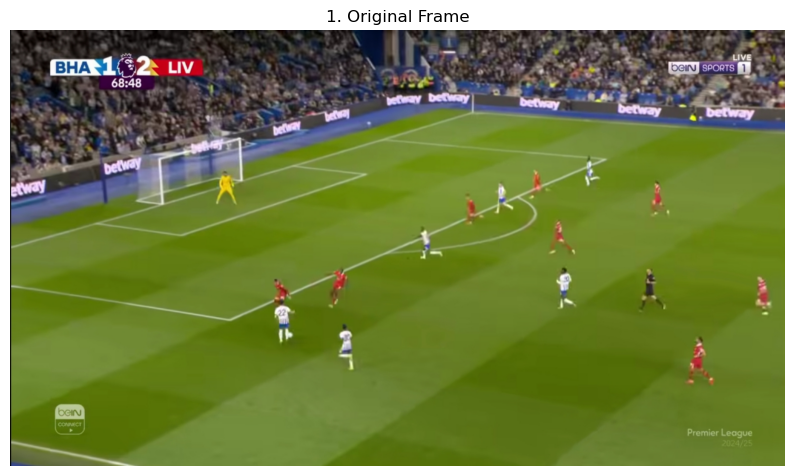

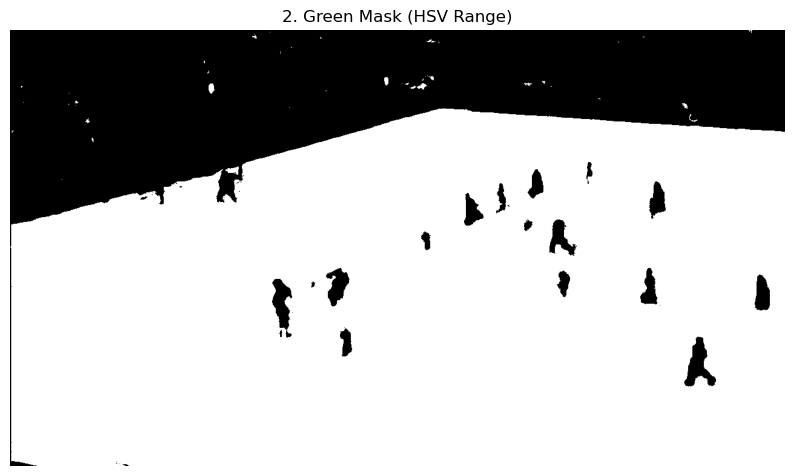

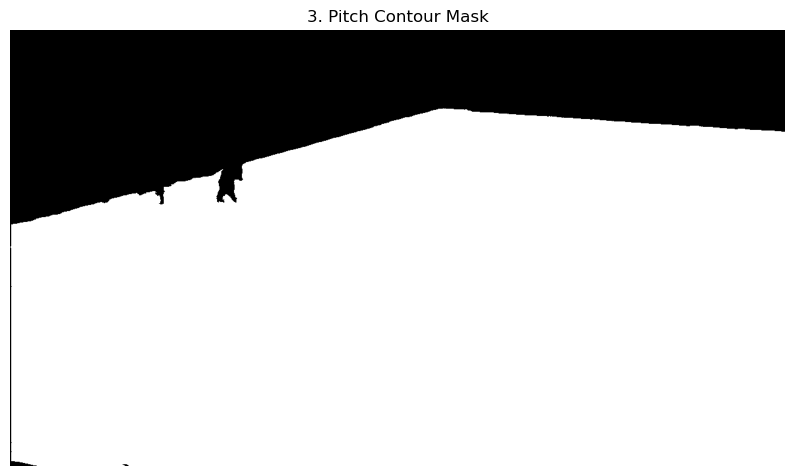

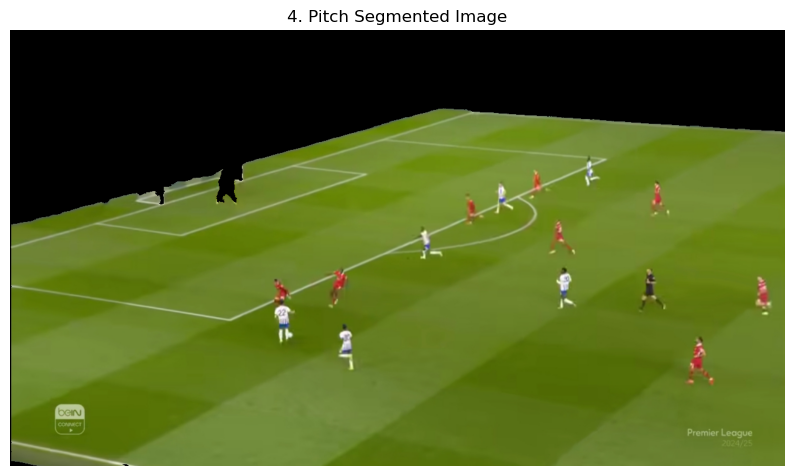

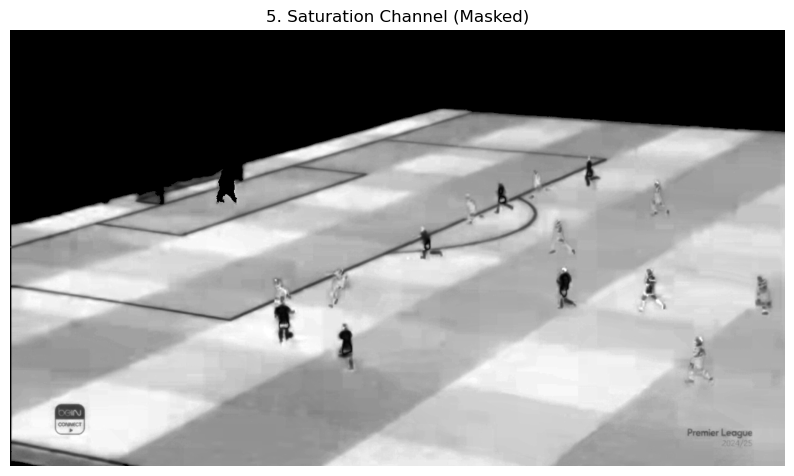

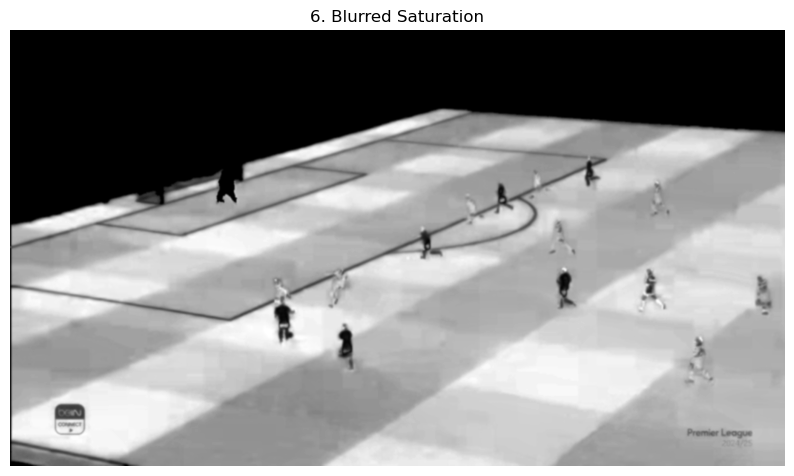

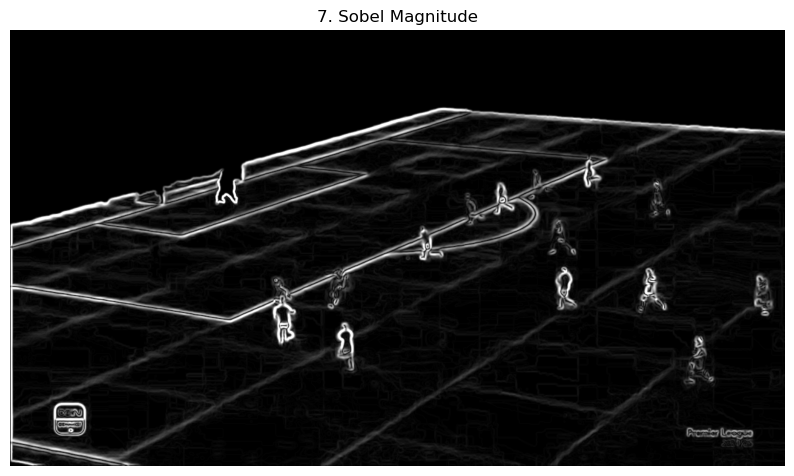

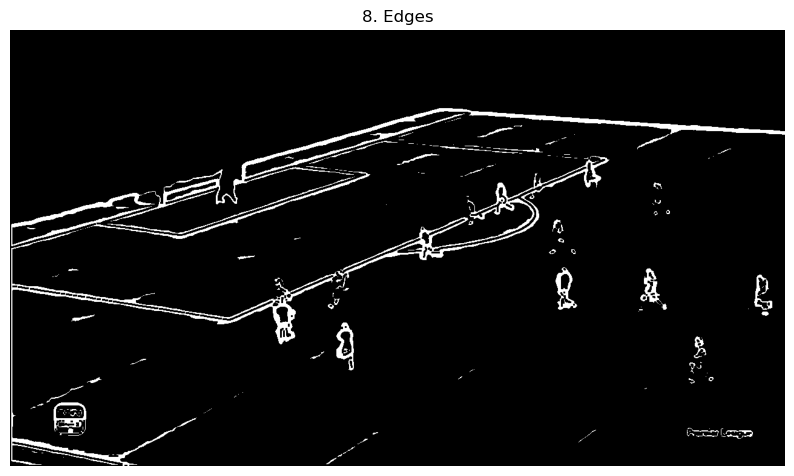

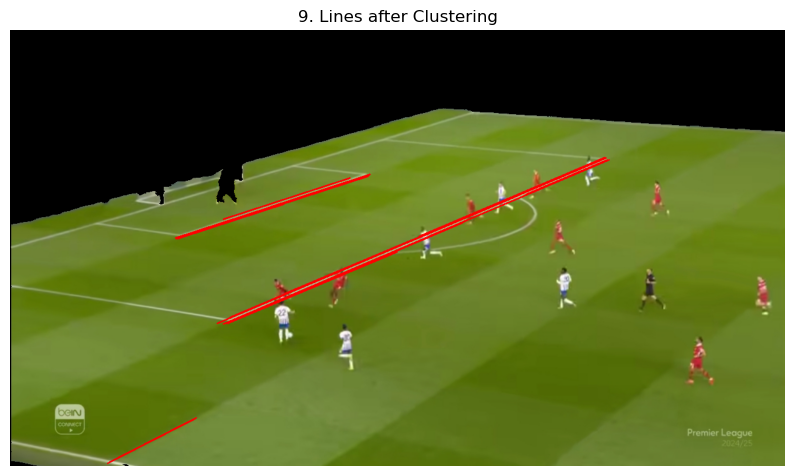

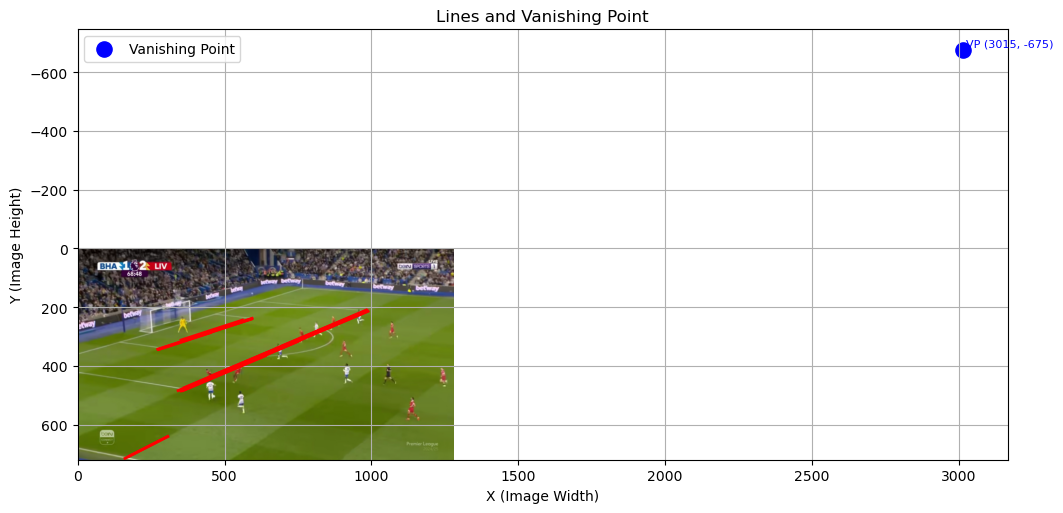


0: 384x640 17 persons, 1355.5ms
Speed: 212.8ms preprocess, 1355.5ms inference, 131.6ms postprocess per image at shape (1, 3, 384, 640)


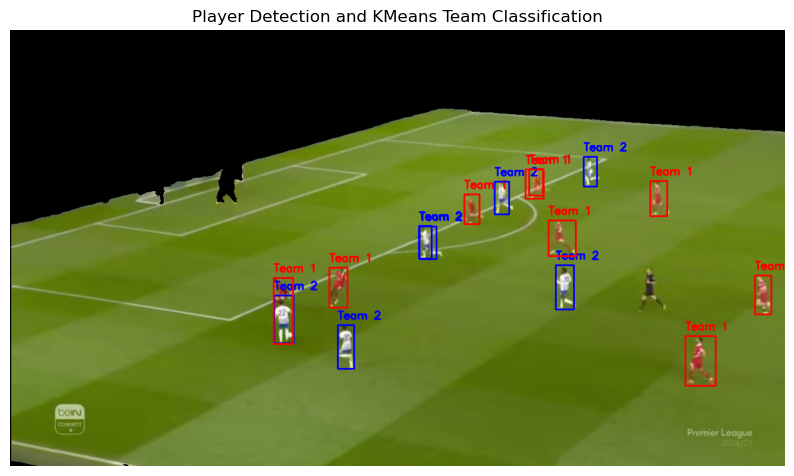

C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


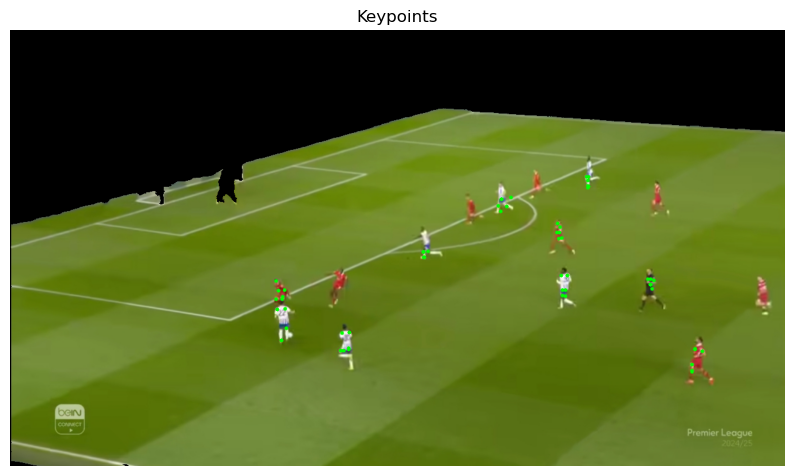

In [69]:
image_path = "../datasets/images/liv.jpg"
original, pitch_only, pitch_mask = segment_pitch_area(image_path)

edges = extract_edges_sobel(pitch_only, pitch_mask)
final_img, final_lines = detect_lines_with_clustering(edges, pitch_only)

# estimating VP 
vanishing_point = compute_vanishing_point(final_lines)
plot_lines_and_vp(original, final_lines, vanishing_point)
# Detect players
img_with_players, player_boxes = detect_players_yolov8(pitch_only)
# Classify players using KMeans based on shirt color
classified_img, team_labels, filtered_boxes = classify_players_kmeans(img_with_players, player_boxes)
# Detect keypoints
pose_rgb, all_keypoints = extract_keypoints_for_detected_players(img_with_players, filtered_boxes)

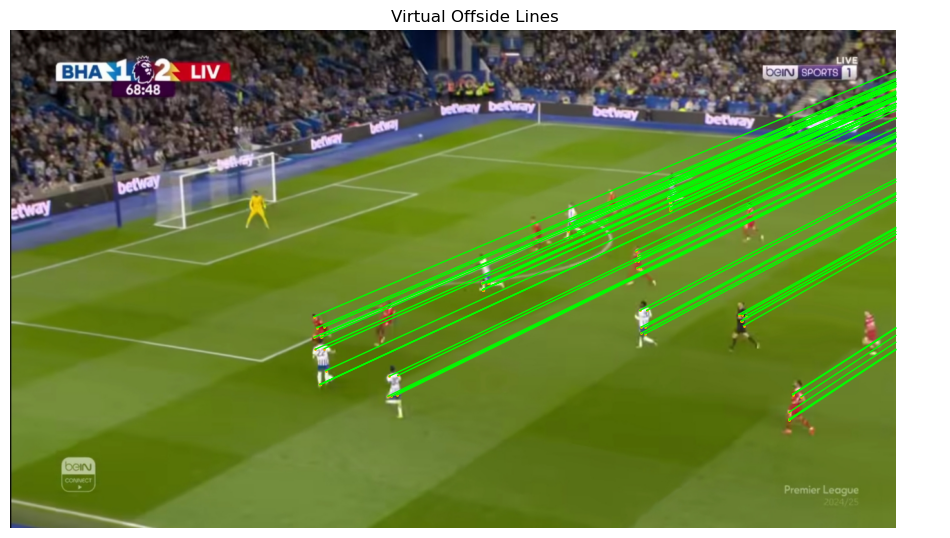

In [72]:
# def draw_offside_lines(image_rgb, keypoints, vanishing_point):
#     output_img = image_rgb.copy()
#     fig, ax = plt.subplots(figsize=(12, 8))
#     ax.imshow(output_img)

#     for kp in keypoints:
#         x, y, v = kp
#         if v > 0:  # Only use visible keypoints
#             ax.plot([x, vanishing_point[0]], [y, vanishing_point[1]], color='lime', linewidth=1, linestyle='-')
#             ax.scatter(x, y, color='orange', s=40)

#     # Draw vanishing point
#     ax.scatter(vanishing_point[0], vanishing_point[1], color='blue', s=120, label='Vanishing Point')
#     ax.text(vanishing_point[0]+10, vanishing_point[1]-10, f'VP ({int(vanishing_point[0])}, {int(vanishing_point[1])})', color='blue', fontsize=8)

#     ax.set_title("Virtual Offside Lines from Keypoints to Vanishing Point")
#     ax.legend()
#     ax.axis('off')
#     plt.show()


def draw_offside_lines(image_rgb, keypoints, vanishing_point):
    def clip_line_to_image(x1, y1, x2, y2, width, height):
        from shapely.geometry import LineString, box
        line = LineString([(x1, y1), (x2, y2)])
        image_box = box(0, 0, width, height)
        intersection = line.intersection(image_box)
        if intersection.is_empty:
            return None
        if intersection.geom_type == 'LineString':
            x1_clip, y1_clip, x2_clip, y2_clip = *intersection.coords[0], *intersection.coords[-1]
            return int(x1_clip), int(y1_clip), int(x2_clip), int(y2_clip)
        return None

    output_img = image_rgb.copy()
    h, w = output_img.shape[:2]
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(output_img)

    for kp in keypoints:
        x, y, v = kp
        if v > 0:  # Only use visible keypoints
            clipped = clip_line_to_image(x, y, vanishing_point[0], vanishing_point[1], w, h)
            if clipped:
                x1_clip, y1_clip, x2_clip, y2_clip = clipped
                ax.plot([x1_clip, x2_clip], [y1_clip, y2_clip], color='lime', linewidth=1, linestyle='-')
                ax.scatter(x, y, color='orange', s=1)

    ax.set_title("Virtual Offside Lines")
    ax.axis('off')
    plt.show()


draw_offside_lines(original, all_keypoints, vanishing_point)